In [27]:
import torch
import matplotlib.pyplot
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
from torch.utils.data import sampler

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cpu')

In [9]:
raw = torchvision.datasets.CIFAR10('./', train=True, download=True)
raw

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

In [46]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToImagePIL(),
            ])


NUM_TRAIN = 49000

ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


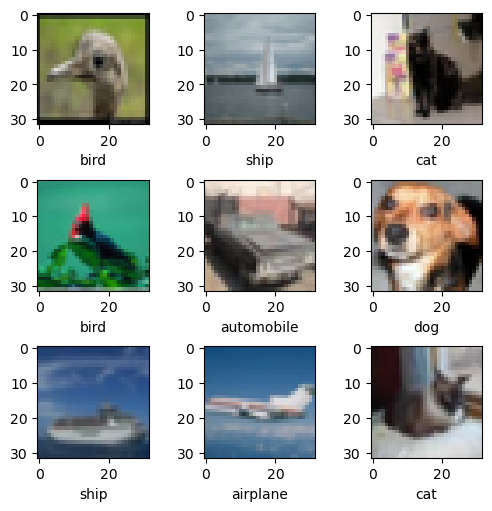

In [66]:
inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])


fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')
xb, yb = next(iter(dl_train))

for r in range(3):
    for c in range(3):
        ax = axs[r][c]
        x = xb[r*3 + c]
        y = yb[r*3 + c]
        x = inv_transform(x)
        ax.imshow(x)
        ax.set_xlabel(ds_train.classes[y])


## Model

In [762]:
# y: (B)  yh: (B)
y = torch.tensor([1, 2, 3, 4])
yh = torch.tensor([1, 0, 0, 0])

def accuracy(y, yh):
    return (y == yh).float().mean()

accuracy(y, yh)

tensor(0.2500)

In [820]:
@torch.no_grad()
def eval_split(split, model, samples=None):
    batch_size = 256
    ds = train_ds if split == "train" else valid_ds
    dl = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True, generator=torch.Generator())
    lossi = []
    acci = []

    for i, (xb, yb) in enumerate(dl):
        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        lossi.append(loss.item())
        
        prob = F.softmax(logits, dim=1) # (B, 10)
        yh = torch.argmax(prob, dim=1) # (B)
        acc = accuracy(yh, yb)
        acci.append(acc.item())

        if samples and i * batch_size > samples:
            break

    return torch.tensor(lossi).mean().item(), torch.tensor(acci).mean().item()

In [742]:
class MLP(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        gain = nn.init.calculate_gain('tanh') 

        self.linear1 = nn.Linear(32*32*3, 1024)
        # nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.linear1.weight, gain)

        self.linear2 = nn.Linear(1024, 512)
        # nn.init.kaiming_normal_(self.linear2.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.linear2.weight, gain)

        self.linear3 = nn.Linear(512, 256)
        # nn.init.kaiming_normal_(self.linear3.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.linear3.weight, gain)

        self.linear4 = nn.Linear(256, 10)
        self.linear4.bias = nn.Parameter(torch.zeros_like(self.linear4.bias))
        self.h = [0] * 5

    
    # x: (B, 3, 32, 32)
    # y: (B, 10)
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        self.h[0] = x

        x = self.linear1(x).tanh()
        self.h[1] = x

        x = self.linear2(x).tanh()
        self.h[2] = x

        x = self.linear3(x).tanh()
        self.h[3] = x

        x = self.linear4(x)
        self.h[4] = x

        return x

model = MLP()
sum([p.numel() for p in model.parameters()])

3805450

## Experiement

In [ ]:
a = nn.Linear(32*32*3, 1024)
nn.init.kaiming_normal_(a.weight, nonlinearity='relu')
a.weight.mean(), a.weight.std(), a.bias.mean(), a.bias.std()

In [ ]:
torch.tensor(2).sqrt() / torch.tensor(32*32*3).sqrt()

In [ ]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
xb, yb = next(iter(dl))


xb = xb.view(-1, 32*32*3)
val, axis = xb.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="xb")

linear1 = nn.Linear(32*32*3, 1024)
linear1.requires_grad_(False)
a = linear1(xb)
val, axis = a.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="linear")


linear2 = nn.Linear(32*32*3, 1024)
linear2.requires_grad_(False)
nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
a = linear2(xb)
val, axis = a.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="linear2")

plt.legend()

## Sanity Check

Check if model has the capacity of overfit a small batch

In [ ]:
model = MLP()
dl = torch.utils.data.DataLoader(train_ds, batch_size=10)
optimizer = torch.optim.Adam(model.parameters())
xb, yb = next(iter(dl))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"{loss.item():.4f}")

Initial loss check

In [ ]:
model = MLP()
dl = torch.utils.data.DataLoader(train_ds, batch_size=512)
xb, yb = next(iter(dl))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("loss:", loss.item())
print("chance:", -torch.tensor(1/10).log().item())

Activation distribution check

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, t in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, t.mean(), t.std(), (t.abs() > 0.99).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
layers = [model.linear1, model.linear2, model.linear3, model.linear4]

for i, l in enumerate(layers):
    t = l.weight.grad
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('gradient distribution');

## Training

In [804]:
model = MLP()
dl = torch.utils.data.DataLoader(train_ds, batch_size=32)
lr = 0.005
epoch = 20
i = 0
n = len(dl) * epoch

metrics = []
update_ratio = []
optimizer = torch.optim.SGD(model.parameters(), lr, weight_decay=0.001)

@torch.no_grad()
def cal_ratio(param):
    update = -lr * param.grad 
    return update.std() / param.std()

for e in range(epoch):
    if e > 3:
        lr = 0.001
    
    for xb, yb in dl:
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 1000 == 0:
            tr_loss, tr_acc = eval_split("train", model, samples=1000)
            va_loss, va_acc = eval_split("valid", model, samples=1000)
            print(f"{i/n:.2f}: {tr_loss:.4f} {tr_acc:.4f} {va_loss:.4f} {va_acc:.4f}")
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))

            r = [cal_ratio(p) for p in model.parameters() if p.dim() == 2]
            update_ratio.append(r)

        i += 1
        optimizer.step()

0.00: 2.3512 0.1078 2.3612 0.1125
0.04: 1.8011 0.4023 1.8245 0.3672
0.07: 1.7079 0.4289 1.7476 0.4023
0.11: 1.6335 0.4594 1.7014 0.4133
0.14: 1.5694 0.4836 1.6739 0.4305
0.18: 1.5064 0.5109 1.6397 0.4422
0.21: 1.4412 0.5312 1.6283 0.4367
0.25: 1.3919 0.5430 1.6204 0.4352
0.28: 1.3197 0.5773 1.6113 0.4523
0.32: 1.2728 0.5891 1.6022 0.4570
0.36: 1.2210 0.5930 1.5924 0.4586
0.39: 1.1735 0.6234 1.6165 0.4586
0.43: 1.0867 0.6508 1.5894 0.4664
0.46: 1.0471 0.6727 1.6127 0.4609
0.50: 0.9837 0.6750 1.6178 0.4633
0.53: 0.9392 0.7102 1.6577 0.4594
0.57: 0.8642 0.7312 1.6225 0.4664
0.60: 0.8219 0.7492 1.6712 0.4484
0.64: 0.7737 0.7695 1.6910 0.4727
0.68: 0.7168 0.7758 1.6914 0.4625
0.71: 0.6713 0.8031 1.7531 0.4516
0.75: 0.6360 0.8203 1.7824 0.4578
0.78: 0.5775 0.8336 1.8090 0.4430
0.82: 0.5507 0.8445 1.8724 0.4391
0.85: 0.5189 0.8445 1.9414 0.4461
0.89: 0.5099 0.8484 1.9631 0.4578
0.92: 0.4450 0.8711 1.9906 0.4570
0.96: 0.3813 0.8992 2.0299 0.4570
1.00: 0.5693 0.8359 2.2214 0.4266


In [822]:
eval_split("train", model), eval_split("valid", model)

((0.36063921451568604, 0.9018261432647705), (2.1245644092559814, 0.435546875))

In [ ]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)
plt.plot(tr_loss, label="tr_loss")
plt.plot(va_loss, label="va_loss")

In [ ]:
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)
plt.plot(tr_acc, label="tr_acc")
plt.plot(va_acc, label="va_acc")

In [ ]:
# unpack an array update_ratio of tuple into a tuple of array
ur = list(zip(*update_ratio))
for i, r in enumerate(ur):
    plt.plot(np.log10(r), label=f"param {i}")

plt.legend()

In [ ]:
@torch.no_grad()
def predict(x):
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    return yh

tensor(120.6538) tensor(64.1936)


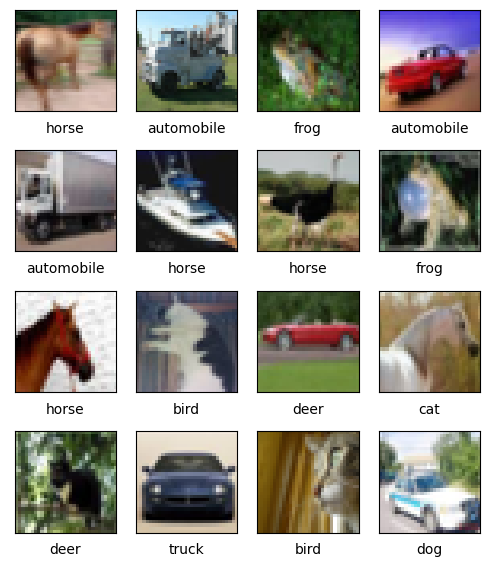

In [817]:
dl = torch.utils.data.DataLoader(valid_ds, batch_size=16, shuffle=True)
x, y = next(iter(dl))
yh = predict(x)

print(mean, std)
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    xi = (x[i] * std + mean).int()
    plt.imshow(xi)
    plt.xlabel(raw.classes[yh[i]])

# Log

- tanh, data in range [0,1]: 1.4300, 0.4986
- data processing (standardize): (0.3606, 0.9018, 2.124, 0.4355)) 